# Lab3: Constrained optimization: equality constraints

**Carla Sendra Balcells**\
**Roxane Le Tensorer**\
**Rachel Trimble**

In this lab we focused on optimization in the presence of equality constraints. To achieve this we transform the constrained optimization problem into an unconstrained optimization problem through the use of Lagrange multipliers.


## 1. Basic iterative approach

To tackle the optimization problem in the presence of equality constraints we use sequential quadratic programming, an iterative method for when the objective function and the constraints are twice continuously differentiable.<br>
The method solves a sequence of optimization subproblems, with each iteration optimising a quadratic model of the objective subject to a linearization of the constraints. <br>

In our case the problem has only equality constraints, therefore the method is equivalent to applying Newton's method to the first-order optimality conditions, or Karush–Kuhn–Tucker (KKT) conditions, of the problem.

There are several techniques available to solve these problems, we will focus on the feasible-point methods which minimises f(x) while following the path of h(x)=0.

We apply the Sequential Quadratic Optimization method to the problem:

Minimize $f(x1, x2)=e^{3x_1}+e^{-4x_2}$ <br>
Subject to $h(x1, x2)=x_1^2+x_2^2-1$<br>




In [145]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def f(x):
    return np.exp(3*x[0])+np.exp(-4*x[1])


def h(x):
    return x[0]**2+x[1]**2-1

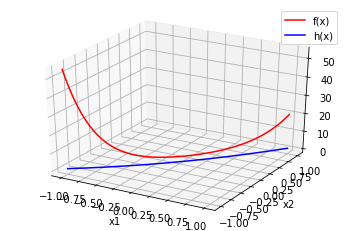

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x1_axis = np.linspace(-1, 1, 1000)
x2_axis = np.linspace(-1, 1, 1000)
x_values = np.array([x1_axis, x2_axis])
h_values = h(x_values)
f_values = f(x_values)
ax.plot3D(x1_axis, x2_axis, f_values, 'red', label='f(x)')
ax.plot3D(x1_axis, x2_axis, h_values, 'blue', label='h(x)')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend()
plt.show()

In [102]:
def grad_f(x):
    return np.array([3*np.exp(3*x[0]), -4*np.exp(-4*x[1])])


def grad_h(x):
    return np.array([2*x[0], 2*x[1]])

In [6]:
def grad_L(grad_f_, grad_h_, lambd):
    return grad_f_ - lambd*grad_h_

In [7]:
def grad2_f(x):
    return np.array([[9*np.exp(3*x[0]), 0], [0, 16*np.exp(-4*x[1])]])


def grad2_h(x):
    return np.array([[2, 0], [0, 2]])

In [12]:
def KKT(grad_L_, grad2_L_, grad_h_, h_):
    n = grad2_L_.shape[0]
    m = grad2_L_.shape[1]
    
    A = np.zeros((n+1, m+1))
    A[:-1, :-1] = grad2_L_
    A[:-1, -1] = -grad_h_.T
    A[-1, :-1] = -grad_h_.T[0]
    
    b = np.zeros((n+1, 1))
    b[:-1] = -grad_L_
    b[-1, 0] = h_
    
    z = np.linalg.solve(A, b)
    
    return z

We create now the function with the stopping condition based on the Lagragian gradient: if the norm of this matrix is small enough, the algorithm stops because it means that the point is probably very close from the minimum. It also stops if the difference between two successives values of x is small enough.

In [72]:
def main(x0, lambd0, alpha):
 
    grad_L_ = grad_L(grad_f(x0), grad_h(x0), lambd0)
    x_old = np.array([[0, 0]])
    x=0

    while (np.linalg.norm(grad_L_, 2) > 10e-14) and not np.allclose(x_old, x0, 10e-4):
        
        
        grad_h_ = grad_h(x0)
        h_ = h(x0)
        grad2_h_ = grad2_h(x0)
        

        grad_f_ = grad_f(x0)
        grad2_f_ = grad2_f(x0)
        

        grad_L_ = grad_L(grad_f_, grad_h_, lambd0)
        grad2_L_ = grad_L(grad2_f_, grad2_h_, lambd0)
        

        z = KKT(grad_L_, grad2_L_, grad_h_, h_)

        x = x0 + alpha*z[:-1]
        lambd = lambd0 + alpha*z[-1]

        x_old = x0
        x0 = x
        lambd0 = lambd
        
        if np.isnan(x0[0]):
            break
        
        
    return x0, lambd0

In [73]:
x0 = np.array([[-1],[1]])
lambd0 = -1
alpha = 1

main(x0, lambd0, alpha)

(array([[-0.74833549],
        [ 0.66332043]]),
 array([-0.21232494]))

We find the solution is $x=(-0.74833549, 0.66332043)$ and $\lambda = -0.21232494$

It should be noted that this point is not a minimum but merly a saddle point of the Lagrangian, this is because the Hessian matrix of the Lagrangian is an indefinite matrix (It has two positive and one negative eigenvalues).

### 2. Drawbacks of the basic iterative method

If there are no inequality constraints the iterates are identical to the Newton iterates for solving, hence if the initial solution vector are sufficiently close to the optimal solution solving the quadratic programs leads to the quadratic convergence of the iterates to the optimal solution.

However if the initial point is not near the optimal solution we do not reach convergence, since the function can have any local behaviour far from the optimal solution. To demonstrate this we take the initial point $x_0=(100,1)$

In [103]:
x0 = np.array([[100],[1]])
lambd0 = -1
alpha = 1

main(x0, lambd0, alpha)

<ipython-input-102-b69adb578d5e>:2: RuntimeWarning: overflow encountered in exp
  return np.array([3*np.exp(3*x[0]), -4*np.exp(-4*x[1])])


(array([[nan],
        [nan]]),
 array([nan]))

As we can see from the above when the starting point is not near the optimal point we do not get convergence. In fact we get a warning indicating that python can not perform the exponential to the power of a high number, indicating that the algorithm moved in a different direction than the optimal solution and hence convergence was not reached.<br>
The algorithm breaks because the obtained x is not a number. Indeed, during the calculus of the gradient of f, the $x[1]$ value was -4966. Then, python had to calculate $exp(-4*x[1]) \approx exp(20000)$, which is way too much since the higher exponential value this tool can calculate is $\approx exp(710)$. <br>
The reason of this huge value can be explained because the goal of the Newton algorithm, as we saw in a previous lab, is to reach a local minimum. When the starting point is too far from the actual minimum, the algorithm could have unwanted behavior, such as the divergence we can see here. A solution for that could be to use a pre-search method in order to have a correct initial guess, this is the purpose of the next part.

### 3. The merit function 

To resolve the issue in the previous section, i.e when the initial point is far from the optimal point, we introduce a merit function. This merit function allows the approximation of an appropriate initial point that can in turn be used with the basic iterative approach. 

For our case we use a quadratic penalty function
$M(x_1, x_2) = f(x_1, x_2) + ρ*h(x_1, x_2)^2$

In [117]:
def f_merit(f_, h_, p):
    return f_ + p * h_**2

def grad_f_merit(grad_f_, grad_h_, h_, p):
    return grad_f_ + 2*p*h_*grad_h_

We create then an algorithm based on the simple gradient descent algorithm, using the merit function. There is still a double stopping condition: the algorithm stops if the gradient of the merit function is too small, or if the difference between two x points is small enough.

In [133]:
def grad_desc(x0, alpha, p):
    
    x_old = np.array([[0, 0]])
    
    iteration = 0
    
    grad_f_merit_ = grad_f_merit(grad_f(x0), grad_h(x0), h(x0), p)
    
    while np.linalg.norm(grad_f_merit_, 2) > 1e-5 and not np.allclose(x_old, x0, 10e-4):
        iteration+=1
        
        grad_f_merit_ = grad_f_merit(grad_f(x0), grad_h(x0), h(x0), p)
        
        grad_norm = grad_f_merit_ / np.linalg.norm(grad_f_merit_, 2)

        x = x0 - alpha * grad_norm
        
        while f_merit(f(x), h(x), p) > f_merit(f(x0), h(x0), p):
            alpha /= 2.0
            x = x0 - alpha * grad_norm
        
        x_old = x0
        x0 = x
        
    return [x0, iteration]

In [134]:
x0 = np.array([[100],[1]])
alpha = 1
p = 10
result = grad_desc(x0, alpha, p)
x0_optimal[0]
print(x0_optimal)

[[-0.74696559]
 [ 0.66718298]]


We chose here to set a high penalty of infeasibility by setting the value of $ρ$ as 10 in the quadratic penalty function to get an approximation for $x_0$<br>
Starting with the same initial point applied in section 2, i.e (100,1), the quadratic penalty function returns an initial point $X_0 = (-0.75242941,0.66654302)$. The euclidian distance between this point and the actual optimal solution found previously is $\approx 0.00572$, which is quite close to the optimal solution.

The choice of $ρ$ seems important in this quadratic penalty function, so we decide to study the effects of changing it. <br>
For that, we create a simple algorithm comparing for several $ρ$ values the number of iterations needed to reach the stopping criterions, and also the euclidian distance between the initial $x_0$ returned by the algorithm and the optimal solution.<br>
This way, we can easily compare the efficiency and the accuracy of this penalty function with several $ρ$ values.

In [173]:
x0 = np.array([[100],[1]])
alpha = 1
minimum = [-0.74833549, 0.66332043]

p=[0.5, 2, 4, 5, 10, 15, 20, 50, 1000]

a = '{0:30}{1:30}{2}'.format("p value", "nb of iterations", "euclidan distance")
print('\033[1m' +a)

for p_ in p:
    result = grad_desc(x0, alpha, p_)
    a = '{0:30}{1:30}{2}'.format(str(p_), str(result[1]), str(math.dist(result[0],minimum)))
    print('\033[0m'+a)

p value                       nb of iterations              euclidan distance
0.5                           113                           0.07864291541401203
2                             139                           0.024304839016628832
4                             165                           0.012700159957782701
5                             188                           0.010199655947788412
10                            271                           0.0057211252703495905
15                            324                           0.003662077685362329
20                            389                           0.003348487684059907
50                            807                           0.0040982787695445656
1000                          1008                          0.6283881097533516


We can see now that, for this specific function, $ρ$ value doesn't need to be bigger. Indeed, it seems that the smaller this parameter is, the less iterations are needed. On the other hand, a small value of $ρ$ gives also a less precise result, since the euclidian distance is bigger for the small values. <br>
However, this difference is not significative as long as even with $ρ = 0.5$ we still get an euclidian distance lower than $0.08$.  

### 4.The merit function with the basic iterative approach

Now that we have obtained an appropriate estimate for $x_0$, we use it for as a starting point in the basic iterative approach defined in section 1.

In [114]:
x0 = x0_optimal
lambd0 = -1
alpha = 1

main(x0, lambd0, alpha)

(array([[-0.74833549],
        [ 0.66332043]]),
 array([-0.21232494]))

This time we manage to obtain the optimal solution, with the same result we obtained in section 1. We can then try this same algorithm with other values in order to test the efficiency of this double system. <br>
We try first with a bigger value: $x_0 = (220, 100)$

In [200]:
x0 = np.array([[220],[100]])
alpha = 1
lambd0 = -1
p = 10

result = grad_desc(x0, alpha, p)
x0_optimal = result[0]
print(x0_optimal)

main(x0_optimal, lambd0, alpha)

[[-0.75219654]
 [ 0.66753932]]


(array([[-0.74833436],
        [ 0.66332177]]),
 array([-0.21232484]))

The algorithm still works, even if the precision is a little bit lower than what we had before. <br>
However, there is a limit because if we use really high values, the algorithm doesn't work despite the approximation of the minimum with the merit function. <br>
For instance, with $x_0 = (500, 100)$:

In [201]:
x0 = np.array([[500],[100]])
alpha = 1
lambd0 = -1
p = 10

result = grad_desc(x0, alpha, p)
x0_optimal = result[0]
print(x0_optimal)

main(x0_optimal, lambd0, alpha)

[[500]
 [100]]


<ipython-input-102-b69adb578d5e>:2: RuntimeWarning: overflow encountered in exp
  return np.array([3*np.exp(3*x[0]), -4*np.exp(-4*x[1])])


(array([[500],
        [100]]),
 -1)

We get again an error because the system is not able to calculate such high values. <br>

In conclusion, we can see that this method, that is calculating iteratively an approximation of the minimizer thanks to a quadratic penalty function and then use this approximation as the initial point $x_0$ of the Newton Descent algorithm is really efficient to correct the drawback of Newton descent algorithm, when the initial point is too far from the goal.